In [3]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Load data

Let's load our data to analyze. For this example, I'm going to use some stock market data to be able to show some clear trend changes. This data can be downloaded from FRED (https://fred.stlouisfed.org/series/SP500) or just grab it from the examples directory. 

In [4]:
market_df = pd.read_csv('../examples/SP500.csv', index_col='DATE', parse_dates=True)

In [5]:
market_df.head()

,SP500
DATE,
2017-08-30,2457.59
2017-08-29,2446.30
2017-08-28,2444.24
2017-08-25,2443.05
2017-08-24,2438.97


# Prepare for Prophet

In [6]:
df = market_df.reset_index().rename(columns={'DATE':'ds', 'SP500':'y'})
df['y'] = np.log(df['y'])

In [7]:
df.head()

,ds,y
0,2017-08-30,7.806936
1,2017-08-29,7.802332
2,2017-08-28,7.801490
3,2017-08-25,7.801003
4,2017-08-24,7.799331


### let's take a quick look at our data

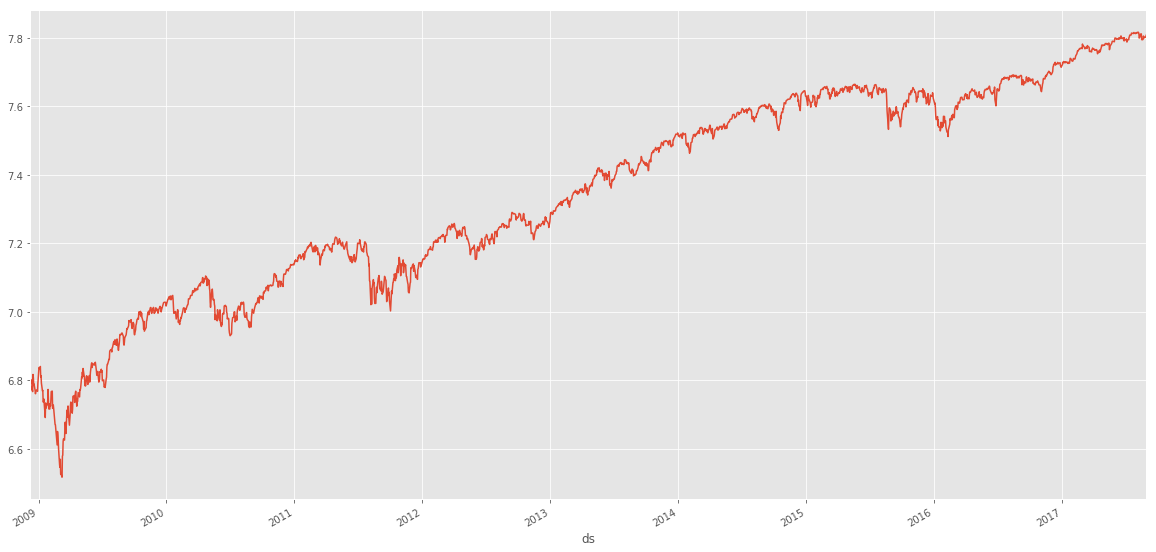

In [8]:
df.set_index('ds').y.plot()

# Running Prophet

As before, let's instantiate prophet and fit our data (including our future dataframe). Take a look at http://pythondata.com/forecasting-time-series-data-prophet-jupyter-notebook/ for more information on the basics of Prophet.

In [9]:
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=366)
forecast = model.predict(future)

### Now, let's take a look at our changepoints.

Prophet creates changespoint for us by default and stores them in  ```.changepoints```. You can see below what the _possible_ changepoints are (they are just shown as dates).   By default, Prophet adds 25 changepoints into the initial 80% of the dataset.  The number of changepoints can be set by using the ```n_changepoints``` parameter when initiallizing prophet (e.g., ```model=Prophet(n_changepoints=30)```


In [10]:
model.changepoints

70     2009-03-20
141    2009-07-01
211    2009-10-09
281    2010-01-21
352    2010-05-04
422    2010-08-12
492    2010-11-19
563    2011-03-04
633    2011-06-14
703    2011-09-22
774    2012-01-04
844    2012-04-16
914    2012-07-25
984    2012-11-05
1055   2013-02-19
1125   2013-05-30
1195   2013-09-09
1266   2013-12-18
1336   2014-04-01
1406   2014-07-11
1477   2014-10-21
1547   2015-02-02
1617   2015-05-13
1688   2015-08-24
1758   2015-12-02
Name: ds, dtype: datetime64[ns]

We can view the _possible_ changepoints by plotting the forecast and changepoints using the following code:


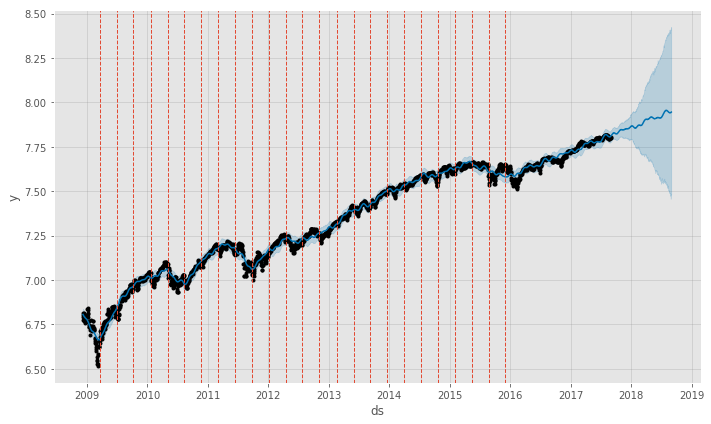

In [95]:
figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

Taking a look at the _possible_ changepoints (drawn in orange/red) in the above chart, we can see they fit pretty well with some of the highs and lows.

Prophet will also let us take a look at the _magnitudes_ of these _possible_ changepoints.  You can look at this visualization with the following code (edited from the fbprophet example here -> https://github.com/facebookincubator/prophet/blob/master/notebooks/trend_changepoints.ipynb)

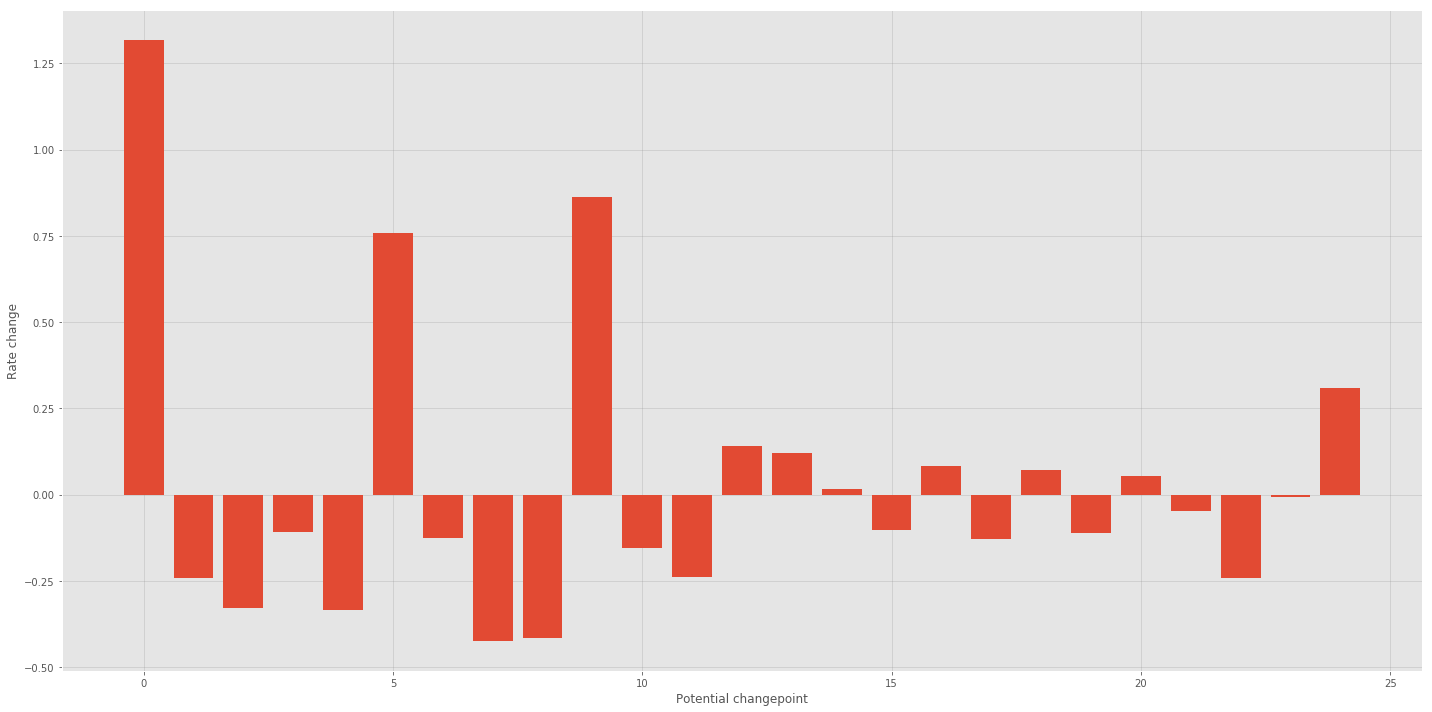

In [97]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

We can see from the above chart, that there are quite a few of these changes points (found between 10 and 20 on the chart) that are very minimal in magnitude and are most likely to be ignored by prophet during forecasting be used in the forecasting.


Now, if we **know** where trends changed in the past, we can add these known changepoints into our dataframe for use by Prophet.

For this data, I'm going to use the FRED website to find some of the low points and high points to use as trend changepoints. Note: In actuality, just because there is a low or high doesn't mean its a **real** changepoint or trend change, but let's assume it does.

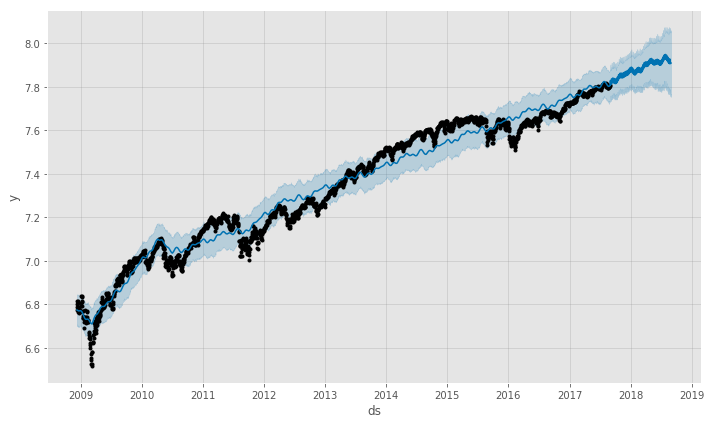

In [12]:
m = Prophet(changepoints=['2009-03-09', '2010-07-02', '2011-09-26', '2012-03-20', '2010-04-06'])
forecast = m.fit(df).predict(future)
m.plot(forecast);


From the above, you can easily see that our identifying just a few changepoints has drastically changed the forecast of this model. There's a significant differrence between this model and the original with the default prophet changepoints.  Unless you are very sure about your trend changepoints in the past, its probably good to keep the defaults that prophet provides.

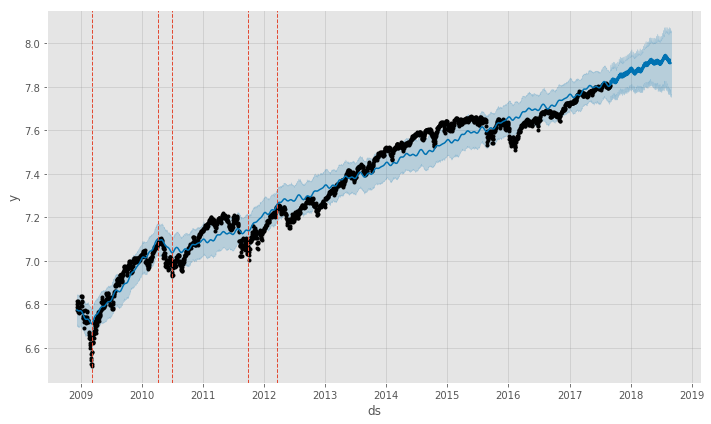

In [13]:
figure = m.plot(forecast)
for changepoint in m.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

# Conclusion

Prophet's use (and accessibility) of trend changepoints is wonderful, especially for those signals / datasets that have significant changes in trend during the lifetime.   

Lastly - please don't think that because prophet does an OK job of forecasting the SP500 chart in this example that you should use it to 'predict' the markets. The markets are awfully tough to forecast...I used this market data because I knew there were some very clear changepoints in the data.